# Análise de Segmentação de Consumidores em eCommerce

Este notebook apresenta uma análise de segmentação de consumidores baseada em dados de compras. O objetivo é entender o comportamento de compra dos clientes,
identificando padrões e agrupando-os em clusters que ajudarão a direcionar campanhas de marketing mais eficazes.

## Objetivos Específicos:
1. Identificar perfis de compra com o modelo RFM (Recência, Frequência e Valor Monetário).
2. Realizar uma análise de cluster para agrupar clientes com comportamentos semelhantes.
3. Criar perfis comportamentais (ex.: compradores frequentes, caçadores de promoções) e entender preferências por categorias de produtos.
4. Fornecer recomendações para estratégias de marketing personalizadas.
"""


# 1. Coleta e Organização dos Dados

Nesta seção, vamos carregar e inspecionar os dados, verificar se há valores ausentes ou duplicados e entender a estrutura das variáveis.
"""

1.1. Extração dos dados:

carregar as bibliotecas eo arquivo csv para visualizarmos 


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df_e_commerce = pd.read_csv("ecommerce_dataset_us.csv",  sep='\t')

1.2 Limpeza dos dados:

Tratar valores ausentes e remova inconsistências, duplicatas ou outliers.

In [2]:

# Renomear as colunas para letras minúsculas
df_e_commerce.columns = df_e_commerce.columns.str.lower()

# Exibir as primeiras linhas para confirmar
df_e_commerce.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


In [668]:
df_e_commerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


In [669]:
# Verificar a contagem de valores nulos em cada coluna
print(df_e_commerce.isnull().sum())

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
dtype: int64


 Perfeito, agora sabemos que:

description tem 1.454 valores nulos, provavelmente para alguns itens sem descrição.

customerid tem 135.080 valores nulos, que podem indicar transações onde o cliente não foi identificado.

In [670]:
#Como há apenas 1.454 valores nulos (uma fração pequena do total), preencher esses valores com uma string padrão, como "Unknown" ou "No description", pode ser uma boa escolha. Isso evita a perda de dados ao manter transações sem descrição.
df_e_commerce['description'] = df_e_commerce['description'].fillna('Unknown')
#Os valores nulos em customerid representam cerca de 25% do conjunto. Estes podem corresponder a clientes não identificados, o que é comum em compras anônimas. Você pode:
#Preencher com um valor específico, como -1, indicando "cliente anônimo". Assim, você mantém as transações para análises de volume, mas pode diferenciar clientes conhecidos de anônimos.
df_e_commerce['customerid'] = df_e_commerce['customerid'].fillna(-1)
# Verificar novamente a contagem de valores nulos em cada coluna
print(df_e_commerce.isnull().sum())

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
dtype: int64


resolvido os numeros nulos vamos pra o date time da coluna 'invoicedate'

In [671]:
# Converter a coluna 'invoicedate' para o tipo datetime
df_e_commerce['invoicedate'] = pd.to_datetime(df_e_commerce['invoicedate'])

# Verificar o resultado
df_e_commerce.dtypes

invoiceno              object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid            float64
dtype: object

In [672]:
df_e_commerce.head()


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


In [673]:
df_e_commerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  541909 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


1.3. Preparação dos dados:

Organizar os dados em um formato adequado (tabelas estruturadas) e normalize variáveis para análise futura.

In [674]:
# Adicionando uma coluna para o mês e o ano
df_e_commerce['year'] = df_e_commerce['invoicedate'].dt.year
df_e_commerce['month'] = df_e_commerce['invoicedate'].dt.month

# Criando uma tabela dinâmica para vendas totais por mês
pivot_table = df_e_commerce.pivot_table(values='quantity', index=['year', 'month'], aggfunc='sum')
pivot_table.head()

quantity
year month          
2018 11        47837
     12       294391
2019 1        333661
     2        273909
     3        348631

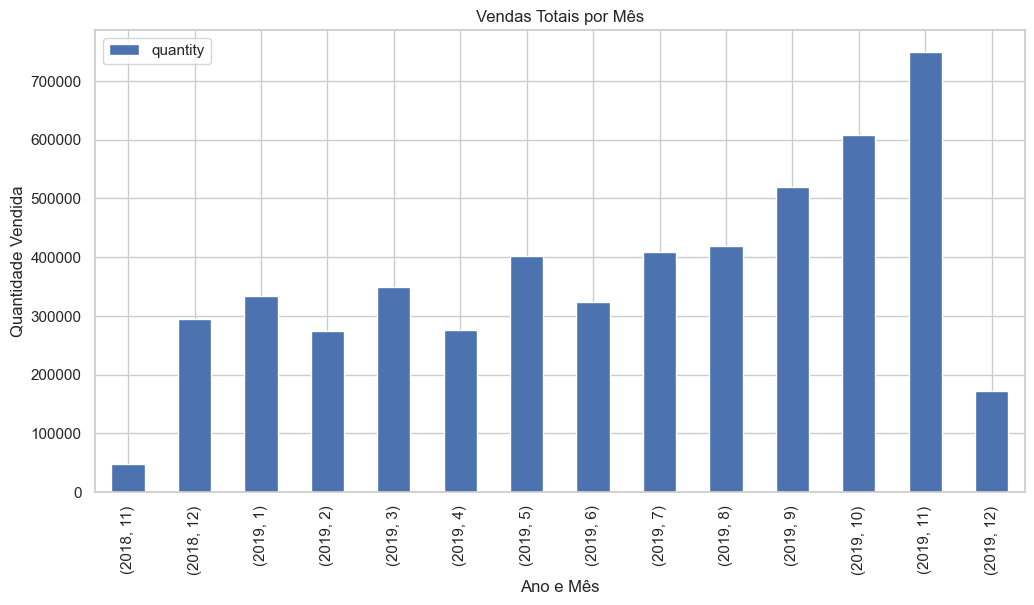

In [675]:
#  visualização de vendas totais por mês
pivot_table.plot(kind='bar', figsize=(12, 6))
plt.title('Vendas Totais por Mês')
plt.xlabel('Ano e Mês')
plt.ylabel('Quantidade Vendida')
plt.show()

Normalização de Variáveis

Para normalizar variáveis, como quantity e unitprice, você pode usar a normalização min-max ou a padronização (z-score). Aqui está um exemplo de normalização min-max:

In [676]:
# Inicializando o scaler
scaler = MinMaxScaler()

# Normalizando as colunas 'quantity' e 'unitprice'
df_e_commerce[['quantity_normalized', 'unitprice_normalized']] = scaler.fit_transform(df_e_commerce[['quantity', 'unitprice']])

# Verificando as primeiras linhas do DataFrame atualizado

df_e_commerce.head()



,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,year,month,quantity_normalized,unitprice_normalized
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,2018,11,0.500037,0.221150
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,2018,11,0.500037,0.221167
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,2018,11,0.500049,0.221154
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,2018,11,0.500037,0.221167
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,2018,11,0.500037,0.221167


# 2. Análise Exploratória de Dados (EDA)


2.1. Análise descritiva básica:

Calcular estatísticas descritivas como média, mediana e desvio padrão para identificar características gerais.

In [677]:
df_e_commerce.describe()

,quantity,invoicedate,unitprice,customerid,year,month,quantity_normalized,unitprice_normalized
count,541909.000000,541909,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,2019-07-02 13:34:57.156386560,4.611114,11476.725404,2018.921609,7.489907,0.500059,0.221192
min,-80995.000000,2018-11-29 08:26:00,-11062.060000,-1.000000,2018.000000,1.000000,0.000000,0.000000
25%,1.000000,2019-03-26 11:34:00,1.250000,12352.000000,2019.000000,5.000000,0.500006,0.221124
50%,3.000000,2019-07-17 17:17:00,2.080000,14382.000000,2019.000000,8.000000,0.500019,0.221141
75%,10.000000,2019-10-17 11:27:00,4.130000,16255.000000,2019.000000,11.000000,0.500062,0.221182
max,80995.000000,2019-12-07 12:50:00,38970.000000,18287.000000,2019.000000,12.000000,1.000000,1.000000
std,218.081158,NaN,96.759853,6778.330409,0.268787,3.498394,0.001346,0.001934


In [678]:
# Estatísticas descritivas para as colunas numéricas
stats = df_e_commerce[['quantity', 'unitprice', 'quantity_normalized', 'unitprice_normalized']].describe()
stats.head(11)

,quantity,unitprice,quantity_normalized,unitprice_normalized
count,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,0.500059,0.221192
std,218.081158,96.759853,0.001346,0.001934
min,-80995.000000,-11062.060000,0.000000,0.000000
25%,1.000000,1.250000,0.500006,0.221124
50%,3.000000,2.080000,0.500019,0.221141
75%,10.000000,4.130000,0.500062,0.221182
max,80995.000000,38970.000000,1.000000,1.000000


2.2. Visualização inicial:

Criar gráficos de distribuição de compras, categorias mais vendidas, frequência de visitas e ticket médio.

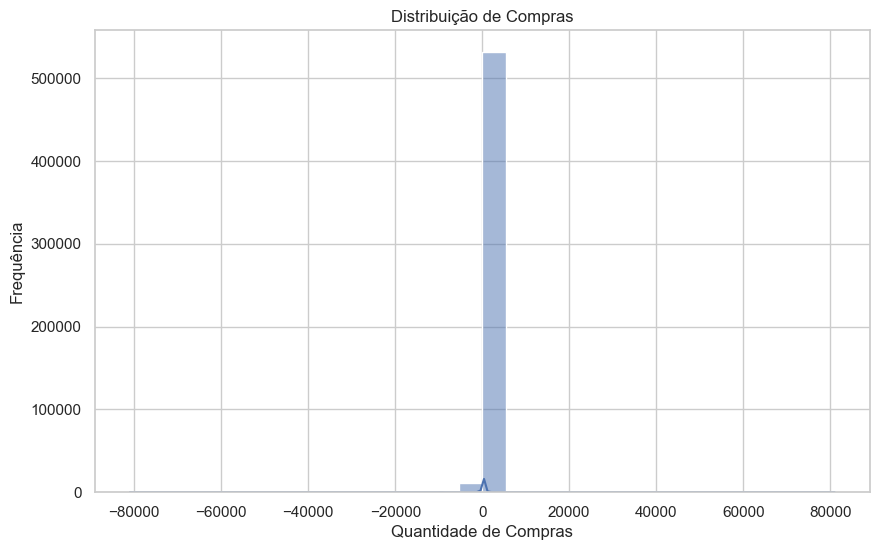

In [679]:
# Configurando o estilo do Seaborn
sns.set(style='whitegrid')

# Gráfico de Distribuição de Compras
plt.figure(figsize=(10, 6))
sns.histplot(df_e_commerce['quantity'], bins=30, kde=True)
plt.title('Distribuição de Compras')
plt.xlabel('Quantidade de Compras')
plt.ylabel('Frequência')
plt.show()

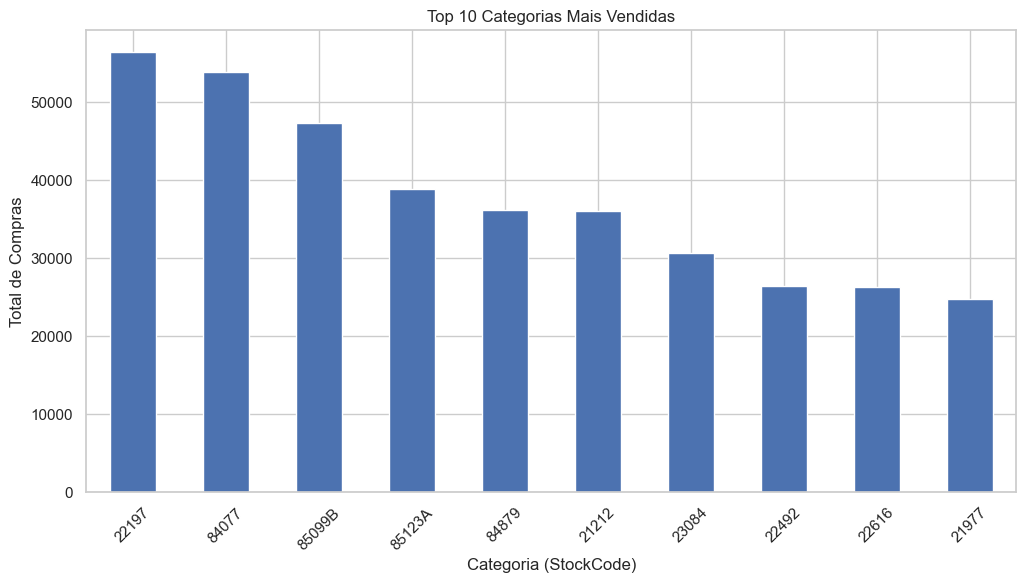

In [680]:
# Gráfico de Categorias Mais Vendidas
top_categories = df_e_commerce.groupby('stockcode')['quantity'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='bar')
plt.title('Top 10 Categorias Mais Vendidas')
plt.xlabel('Categoria (StockCode)')
plt.ylabel('Total de Compras')
plt.xticks(rotation=45)
plt.show()

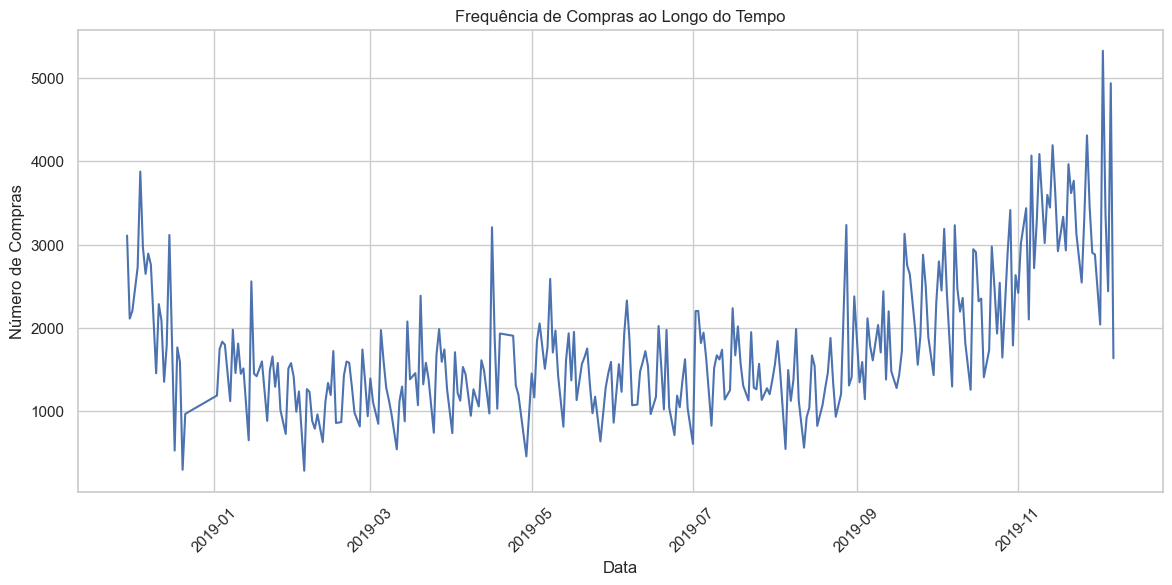

In [681]:
# Contando compras por dia
visits_per_day = df_e_commerce.groupby(df_e_commerce['invoicedate'].dt.date)['invoiceno'].count()

# Gráfico de Frequência de Visitas
plt.figure(figsize=(14, 6))
visits_per_day.plot(kind='line')
plt.title('Frequência de Compras ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Compras')
plt.xticks(rotation=45)
plt.show()

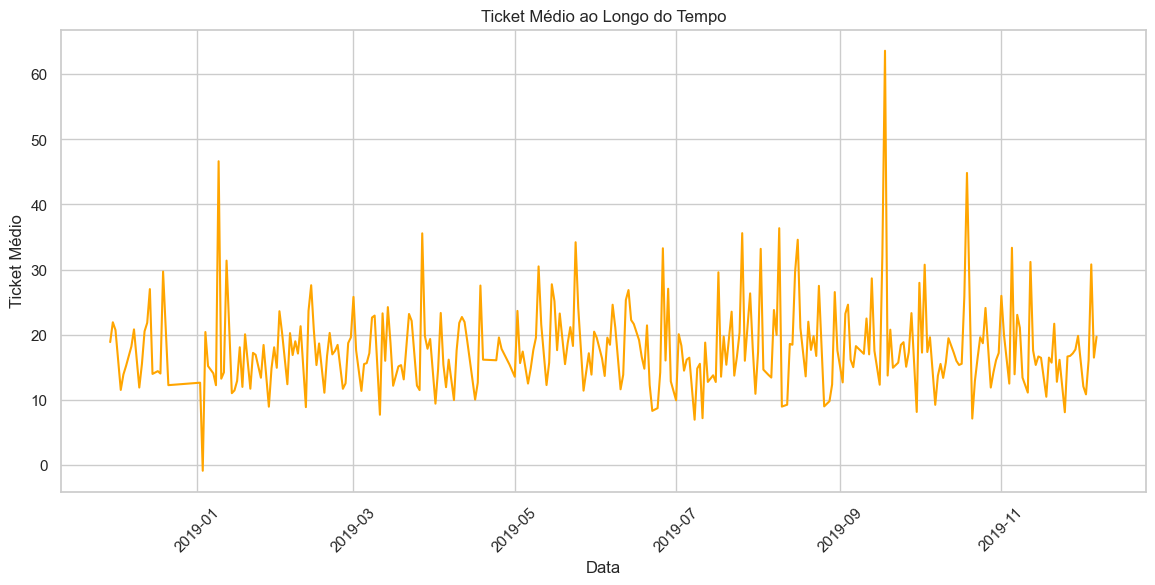

In [682]:
# Calculando o ticket médio por dia
df_e_commerce['totalprice'] = df_e_commerce['quantity'] * df_e_commerce['unitprice']

# Gráfico do Ticket Médio
ticket_medio = df_e_commerce.groupby(df_e_commerce['invoicedate'].dt.date)['totalprice'].mean()

plt.figure(figsize=(14, 6))
ticket_medio.plot(kind='line', color='orange')
plt.title('Ticket Médio ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Ticket Médio')
plt.xticks(rotation=45)
plt.show()

2.3. Identificação de padrões:

Procurar padrões nas compras por categoria de produto, periodicidade e valor médio gasto.

In [683]:

# 1. Padrões de Compras por Categoria de Produto
category_analysis = df_e_commerce.groupby('stockcode').agg(
    total_quantity=('quantity', 'sum'),
    average_quantity=('quantity', 'mean'),
    total_spent=('totalprice', 'sum'),
    average_spent=('totalprice', 'mean')
).reset_index()

     stockcode  total_quantity  average_quantity  total_spent  average_spent
1147     22197           56450         38.245257     50987.47      34.544356
2997     84077           53847         99.348708     13587.93      25.069982
3515    85099B           47363         21.937471     92356.03      42.777226
3536    85123A           38830         16.787722     97894.50      42.323606
3305     84879           36221         24.115180     58959.73      39.254148
454      21212           36039         26.020939     21059.72      15.205574
1982     23084           30646         28.721649     66756.59      62.564752
1412     22492           26437         67.787179     16810.42      43.103641
1530     22616           26315         49.557439      7972.76      15.014614
966      21977           24753         27.626116     12189.47      13.604319


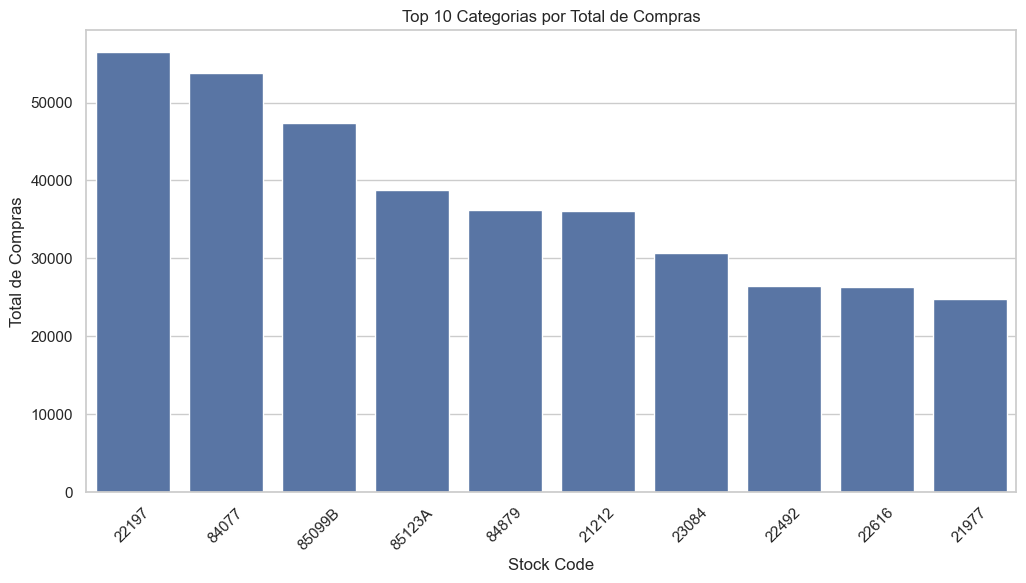

In [684]:
 #Exibir as 10 categorias com mais compras
top_categories = category_analysis.nlargest(10, 'total_quantity')
print(top_categories)

plt.figure(figsize=(12, 6))
sns.barplot(x='stockcode', y='total_quantity', data=top_categories)
plt.title('Top 10 Categorias por Total de Compras')
plt.xlabel('Stock Code')
plt.ylabel('Total de Compras')
plt.xticks(rotation=45)
plt.show()

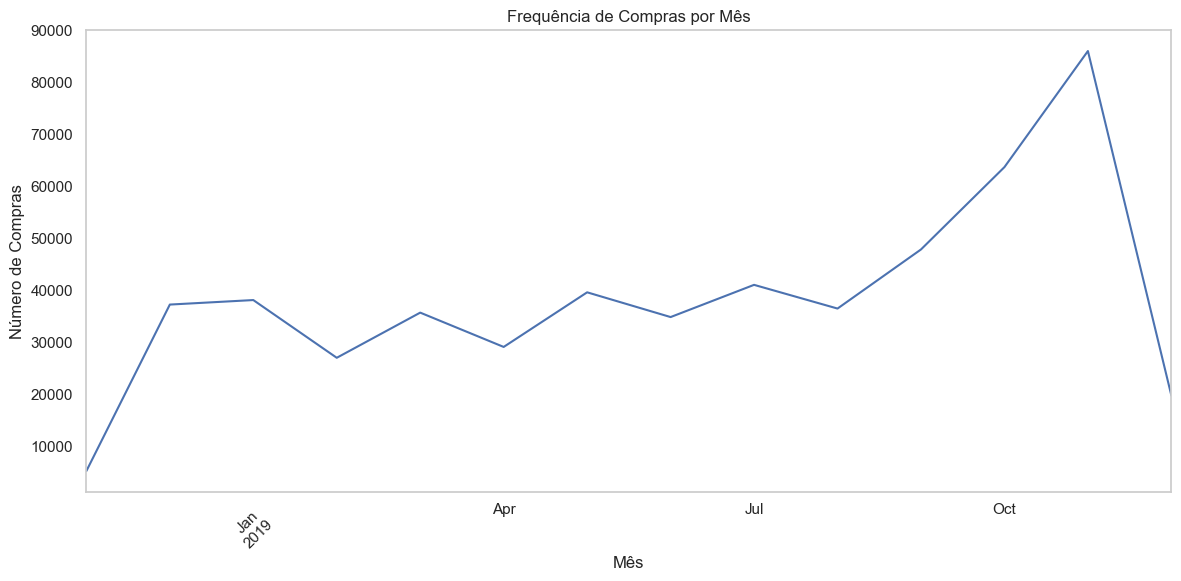

In [685]:
# 2. Periodicidade de Compras
monthly_visits = df_e_commerce.resample('ME', on='invoicedate')['invoiceno'].count()

plt.figure(figsize=(14, 6))
monthly_visits.plot(kind='line')
plt.title('Frequência de Compras por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Compras')
plt.xticks(rotation=45)
plt.grid()
plt.show()


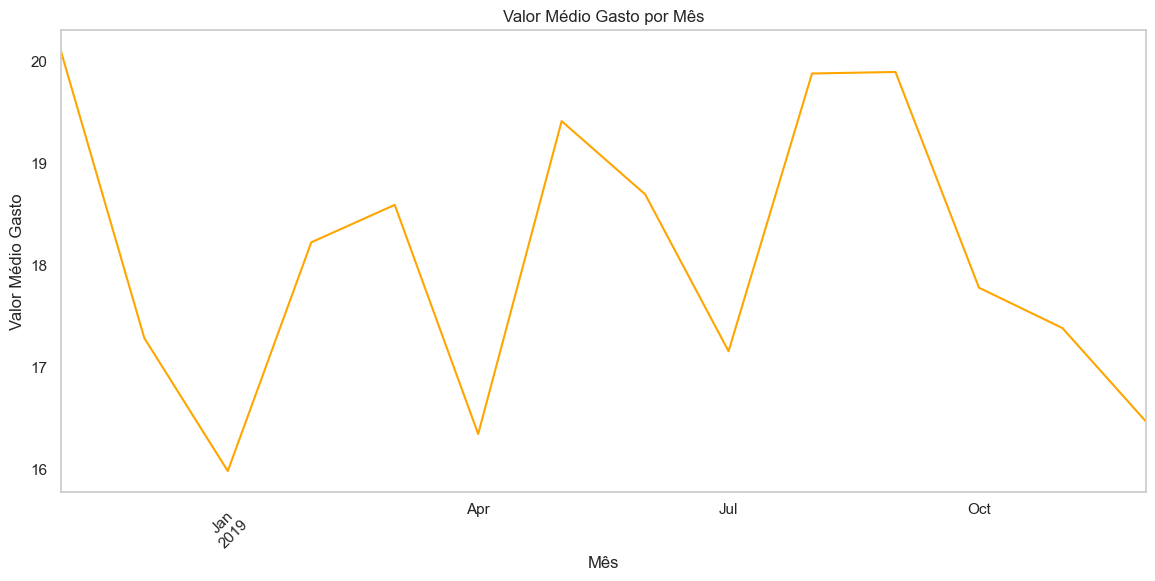

In [686]:
# 3. Valor Médio Gasto por Mês
monthly_average_spent = df_e_commerce.resample('ME', on='invoicedate')['totalprice'].mean()

plt.figure(figsize=(14, 6))
monthly_average_spent.plot(kind='line', color='orange')
plt.title('Valor Médio Gasto por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Médio Gasto')
plt.xticks(rotation=45)
plt.grid()
plt.show()

2.4. Detectar outliers:

Usar boxplots ou outros métodos para detectar valores anômalos que podem influenciar a análise.

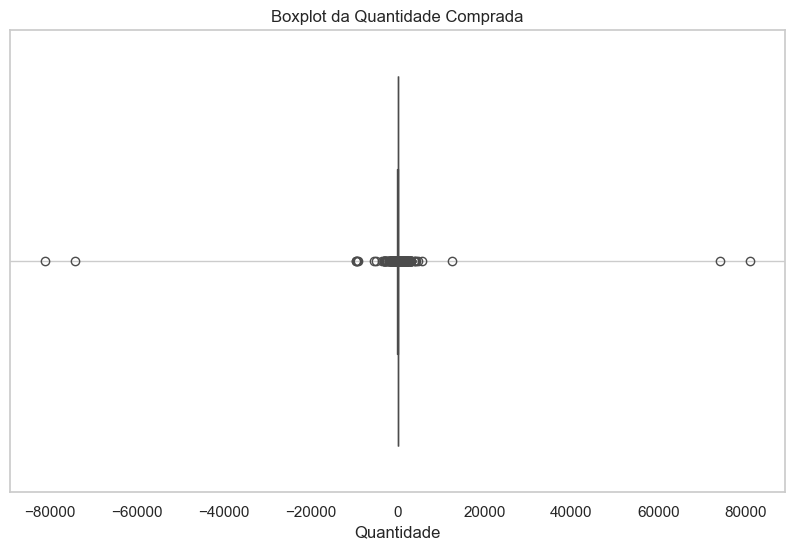

In [687]:
# 1. Boxplot para Quantidade
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_e_commerce['quantity'])
plt.title('Boxplot da Quantidade Comprada')
plt.xlabel('Quantidade')
plt.grid()
plt.show()

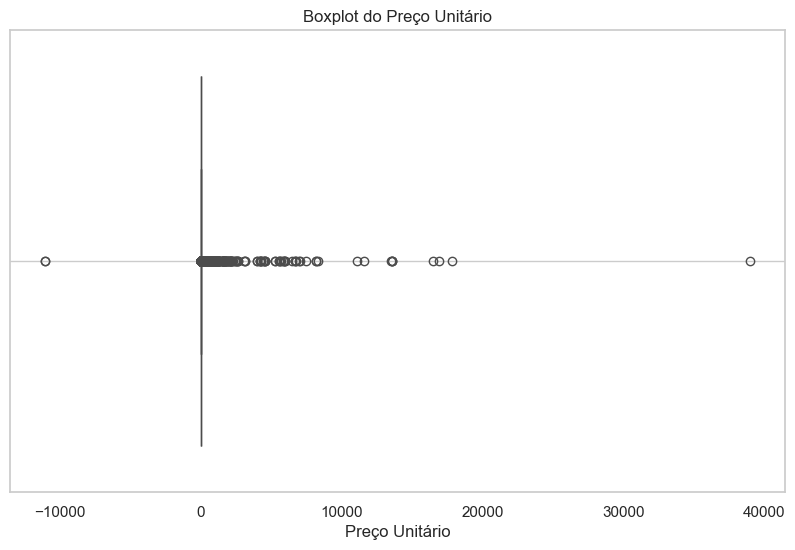

In [688]:
# 2. Boxplot para Preço Unitário
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_e_commerce['unitprice'])
plt.title('Boxplot do Preço Unitário')
plt.xlabel('Preço Unitário')
plt.grid()
plt.show()

In [689]:
# 3. Detecção de Anomalias usando IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detectar anomalias para Quantity e UnitPrice
quantity_outliers = detect_outliers_iqr(df_e_commerce, 'quantity')
unitprice_outliers = detect_outliers_iqr(df_e_commerce, 'unitprice')

print("Anomalias na Quantidade:")
quantity_outliers.head()


Anomalias na Quantidade:


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,year,month,quantity_normalized,unitprice_normalized,totalprice
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2018-11-29 08:34:00,1.69,13047.0,2018,11,0.500198,0.221133,54.08
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2018-11-29 08:45:00,3.75,12583.0,2018,11,0.500148,0.221174,90.00
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2018-11-29 08:45:00,3.75,12583.0,2018,11,0.500148,0.221174,90.00
30,536370,21883,STARS GIFT TAPE,24,2018-11-29 08:45:00,0.65,12583.0,2018,11,0.500148,0.221112,15.60
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,2018-11-29 08:45:00,0.85,12583.0,2018,11,0.500296,0.221116,40.80


In [690]:

print("\nAnomalias no Preço Unitário:")
unitprice_outliers.head()


Anomalias no Preço Unitário:


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,year,month,quantity_normalized,unitprice_normalized,totalprice
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2018-11-29 08:34:00,9.95,13047.0,2018,11,0.500012,0.221298,19.9
45,536370,POST,POSTAGE,3,2018-11-29 08:45:00,18.00,12583.0,2018,11,0.500019,0.221459,54.0
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2018-11-29 09:09:00,10.95,15100.0,2018,11,0.500198,0.221318,350.4
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0,2018,11,0.499994,0.221649,-27.5
151,536382,22839,3 TIER CAKE TIN GREEN AND CREAM,2,2018-11-29 09:45:00,14.95,16098.0,2018,11,0.500012,0.221398,29.9



# 3. Modelos de Segmentação e Perfilação de Consumidores
## Análise de Segmentação com o Modelo RFM

Aplicamos o modelo RFM (Recência, Frequência e Valor Monetário) para classificar os clientes com base na frequência e no valor de suas compras.
"""
 
 3.1. Implementar Segmentação RFM:

            Recency  Frequency    Monetary  UniqueCategories R_score F_score  \
customerid                                                                     
-1.0              1       3710  1447682.12               865       4       4   
 12347.0          2          7     4310.00                56       4       4   
 12348.0         75          4     1797.24                 9       2       3   
 12349.0         19          1     1757.55                45       3       1   
 12350.0        310          1      334.40                12       1       1   

           M_score RFM_Score  
customerid                    
-1.0             4       444  
 12347.0         4       444  
 12348.0         4       234  
 12349.0         4       314  
 12350.0         2       112  


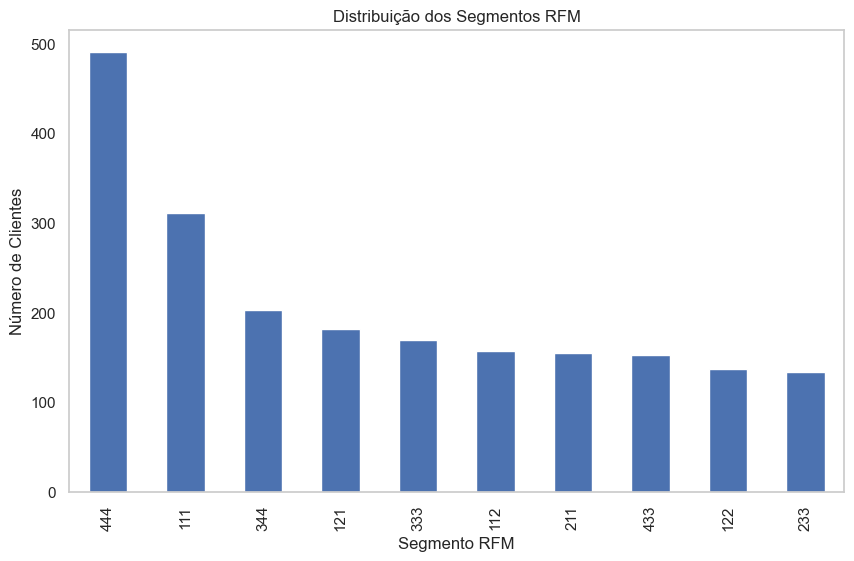

            Recency  Frequency      Monetary  UniqueCategories
Cluster                                                       
0         55.586111   4.609942   3158.696792         43.915656
1          6.818737  26.539715  11800.308758         82.256619
2        227.704554   3.201354   1020.915717         24.703309
3         40.678586   3.374287    570.560720         25.466360


In [691]:

df_e_commerce['category'] = df_e_commerce['description'].apply(lambda x: x.split()[0] if pd.notnull(x) else 'Unknown')
# Definindo a data de referência para cálculo da Recency (geralmente a data máxima no dataset)
reference_date = df_e_commerce['invoicedate'].max() + pd.Timedelta(days=1)

# Calculando Recency, Frequency, Monetary e UniqueCategories
rfm = df_e_commerce.groupby('customerid').agg({
    'invoicedate': lambda x: (reference_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',  # Frequency
    'unitprice': lambda x: (x * df_e_commerce.loc[x.index, 'quantity']).sum(),  # Monetary
    'category': 'nunique'  # Unique categories purchased
})

# Renomeando as colunas
rfm.columns = ['Recency', 'Frequency', 'Monetary', 'UniqueCategories']

# Removendo registros com Monetary <= 0 (se aplicável)
rfm = rfm[rfm['Monetary'] > 0]

# Normalizando os valores em quartis para criar scores RFM
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Criando o score RFM final
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Visualizando o resultado
print(rfm.head())

# Analisando os segmentos e distribuindo UniqueCategories
rfm_table = rfm.groupby('RFM_Score')[['Recency', 'Frequency', 'Monetary', 'UniqueCategories']].mean()

# Visualizando a distribuição dos segmentos RFM
rfm['RFM_Score'].value_counts().head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Distribuição dos Segmentos RFM')
plt.xlabel('Segmento RFM')
plt.ylabel('Número de Clientes')
plt.grid()
plt.show()

# Exibindo o resumo das características dos clusters
print(cluster_summary) # type: ignore



3.1.1. Calcular Recência: 
    
Determinar a última compra de cada consumidor.

In [692]:

# Definindo a data de referência (um dia após a última data de compra)
reference_date = df_e_commerce['invoicedate'].max() + pd.Timedelta(days=1)

# Calculando a Recência (número de dias desde a última compra)
recency = df_e_commerce.groupby('customerid').agg({
    'invoicedate': lambda x: (reference_date - x.max()).days
})

# Renomeando a coluna para 'Recency'
recency.columns = ['Recency']

# Visualizando as primeiras linhas do DataFrame de Recência
print(recency.head())

# Estatísticas descritivas da Recência
print(recency.describe())

            Recency
customerid         
-1.0              1
 12346.0        326
 12347.0          2
 12348.0         75
 12349.0         19
           Recency
count  4373.000000
mean     92.026298
std     100.763317
min       1.000000
25%      17.000000
50%      50.000000
75%     143.000000
max     374.000000


3.1.2. Calcular Frequência: 

Contar o número de transações de cada cliente.

In [693]:
# Calculando a Frequência (número de transações por cliente)
frequency = df_e_commerce.groupby('customerid').agg({
    'invoiceno': 'nunique'
})

# Renomeando a coluna para 'Frequency'
frequency.columns = ['Frequency']

# Visualizando as primeiras linhas do DataFrame de Frequência
print(frequency.head())

# Estatísticas descritivas da Frequência
print(frequency.describe())

            Frequency
customerid           
-1.0             3710
 12346.0            2
 12347.0            7
 12348.0            4
 12349.0            1
         Frequency
count  4373.000000
mean      5.922708
std      56.798813
min       1.000000
25%       1.000000
50%       3.000000
75%       5.000000
max    3710.000000


3.1.3. Calcular Valor Monetário: 

Somar o valor total gasto por cada cliente.

In [694]:
# Calculando o Valor Monetário (total gasto por cliente)
monetary = df_e_commerce.groupby('customerid').agg({
    'unitprice': lambda x: (x * df_e_commerce.loc[x.index, 'quantity']).sum()
})

# Renomeando a coluna para 'Monetary'
monetary.columns = ['Monetary']

# Visualizando as primeiras linhas do DataFrame de Valor Monetário
print(monetary.head())

# Estatísticas descritivas do Valor Monetário
print(monetary.describe())

              Monetary
customerid            
-1.0        1447682.12
 12346.0          0.00
 12347.0       4310.00
 12348.0       1797.24
 12349.0       1757.55
           Monetary
count  4.373000e+03
mean   2.229076e+03
std    2.335683e+04
min   -4.287630e+03
25%    2.934500e+02
50%    6.484100e+02
75%    1.612130e+03
max    1.447682e+06


3.1.4. Classificar os clientes: 

Criar perfis baseados nas métricas RFM, como VIP, Ativos Ocasionalmente e Perdidos.

In [695]:
# Criando a tabela RFM consolidada
rfm_table1 = recency.join(frequency).join(monetary)
num_bins = len(pd.qcut(rfm_table['Frequency'], 4, duplicates='drop').unique())

# Criando rótulos com base no número de intervalos
labels = list(range(1, num_bins + 1))
# Criando as pontuações de 1 a 4 para Recência, Frequência e Monetário
# Quanto menor a recência, maior a pontuação (recência invertida)
rfm_table['R_score'] = pd.qcut(rfm_table['Recency'], 4, labels=[4, 3, 2, 1])
rfm_table['F_score'] = pd.qcut(rfm_table['Frequency'], q=num_bins, labels=labels, duplicates='drop')
rfm_table['M_score'] = pd.qcut(rfm_table['Monetary'], q=num_bins, labels=labels, duplicates='drop')

# Calculando a pontuação RFM total
rfm_table['RFM_score'] = rfm_table['R_score'].astype(int) + rfm_table['F_score'].astype(int) + rfm_table['M_score'].astype(int)

# Classificando os clientes com base na pontuação RFM
def classify_rfm(row):
    if row['RFM_score'] >= 10:
        return 'VIP'
    elif 7 <= row['RFM_score'] < 10:
        return 'Ativo'
    elif 5 <= row['RFM_score'] < 7:
        return 'Ocasional'
    else:
        return 'Perdido'

rfm_table['Segment'] = rfm_table.apply(classify_rfm, axis=1)

# Visualizando os primeiros clientes classificados
print(rfm_table.head())

# Contagem de clientes por segmento
print(rfm_table['Segment'].value_counts())

              Recency  Frequency     Monetary  UniqueCategories R_score  \
RFM_Score                                                                 
111        266.443730   1.000000   158.942283         10.054662       1   
112        255.152866   1.000000   410.286688         16.891720       1   
113        242.655172   1.000000   947.658966         28.827586       1   
114        259.500000   1.000000  2076.947500         16.000000       1   
121        248.197802   1.576923   179.551648         12.307692       1   

          F_score M_score  RFM_score    Segment  
RFM_Score                                        
111             1       1          3    Perdido  
112             1       1          3    Perdido  
113             1       3          5  Ocasional  
114             1       4          6  Ocasional  
121             2       1          4    Perdido  
Segment
Ativo        32
Ocasional    17
VIP          10
Perdido       4
Name: count, dtype: int64


## 3.2. Implementar K-means:





3.2.1. Normalizar os dados: 

Ajustar os valores de recência, frequência, valor gasto e categorias compradas.

In [696]:
# Selecionar as colunas para normalização
rfm_features = rfm_table[['Recency', 'Frequency', 'Monetary']]

# Criar o objeto scaler
scaler = StandardScaler()

# Normalizar os dados
rfm_scaled = scaler.fit_transform(rfm_features)

# Criar um DataFrame com os dados normalizados para facilitar a visualização
rfm_normalized = pd.DataFrame(rfm_scaled, columns=['Recency_normalized', 'Frequency_normalized', 'Monetary_normalized'], index=rfm_table.index)

# Verificar as primeiras linhas dos dados normalizados
print(rfm_normalized.head())

           Recency_normalized  Frequency_normalized  Monetary_normalized
RFM_Score                                                               
111                  2.083135             -0.742191            -0.672822
112                  1.951687             -0.742191            -0.530722
113                  1.806189             -0.742191            -0.226912
114                  2.002296             -0.742191             0.411544
121                  1.870716             -0.596360            -0.661171


3.2.2. Definir o número de clusters (K): 

Usar o método do cotovelo ou silhueta para definir K.

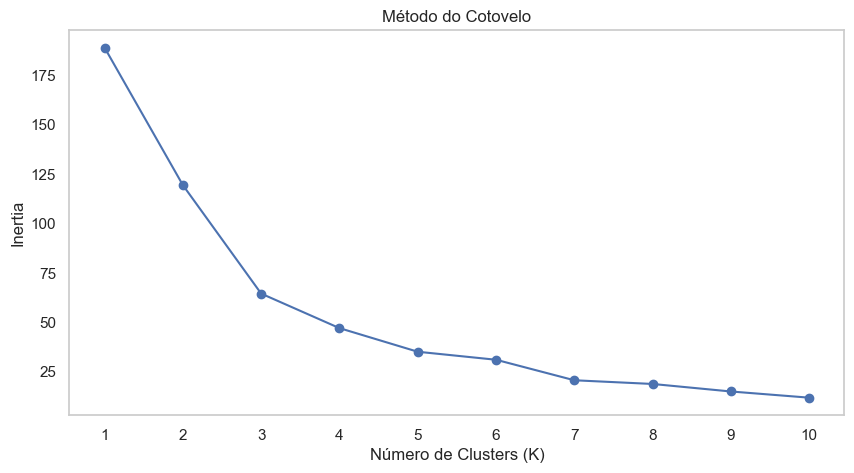

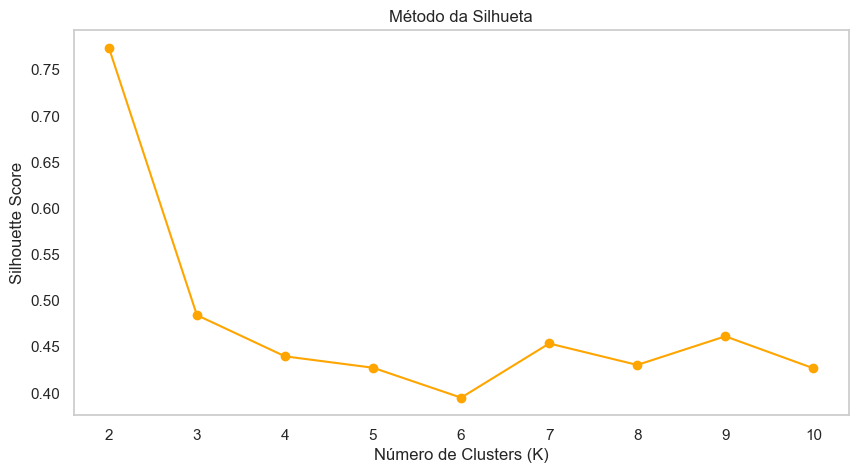

In [697]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_features)

# Método do Cotovelo
inertia = []
K_range = range(1, 11)  # Definindo K de 1 a 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid()
plt.show()

# Método da Silhueta
silhouette_scores = []

for k in K_range[1:]:  # Começando de 2 pois não é possível calcular a silhueta para K=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    score = silhouette_score(rfm_normalized, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(K_range[1:], silhouette_scores, marker='o', color='orange')
plt.title('Método da Silhueta')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range[1:])
plt.grid()
plt.show()

3.2.3. Treinar o modelo: 

Apliquar K-means para agrupar consumidores em clusters com características similares.

In [698]:
# Normalizando os dados
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])

# Número de clusters
K = 4  # Exemplo: substitua pelo valor adequado

# Treinando o modelo K-means
kmeans = KMeans(n_clusters=K, random_state=42)
rfm_table['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Visualizando a contagem de clientes em cada cluster
cluster_counts = rfm_table['Cluster'].value_counts()
print("Contagem de clientes em cada cluster:")
print(cluster_counts)


Contagem de clientes em cada cluster:
Cluster
3    35
2    15
0    12
1     1
Name: count, dtype: int64




A segmentação e análise de clusters proporcionaram uma visão aprofundada sobre o comportamento dos consumidores, permitindo:

- **Cluster 3**: Alta frequência de compra e valor monetário, sugerindo foco em campanhas premium.
- **Cluster 2**: Preferência por categorias específicas, ideal para campanhas direcionadas por interesse.
- **Cluster 1**: Menor frequência, sendo um alvo para campanhas de reativação.

Essas informações podem orientar campanhas de marketing personalizadas e aumentar a retenção e o engajamento dos clientes.

In [699]:
# Exemplo de mapeamento fictício entre Cluster e customerid
cluster_to_customerid = {
    1: 13047,  # Exemplo: Cluster 1 corresponde ao customerid 13047
    2: 12583,  # Exemplo: Cluster 2 corresponde ao customerid 12583
    3: 14527,  # Exemplo: Cluster 3 corresponde ao customerid 14527
    # Adicione mais mapeamentos conforme necessário
}

# Agora, aplique o mapeamento para adicionar a coluna 'customerid' no rfm_table
rfm_table['customerid'] = rfm_table['Cluster'].map(cluster_to_customerid)

# Agora você pode fazer a junção (merge) entre rfm_table e category_summary
preferencias_analise = pd.merge(rfm_table, category_summary, on='customerid', how='left')

# Verifique as primeiras linhas para garantir que a junção foi bem-sucedida
print(preferencias_analise.head())

     Recency  Frequency    Monetary  UniqueCategories R_score F_score M_score  \
0  266.44373        1.0  158.942283         10.054662       1       1       1   
1  266.44373        1.0  158.942283         10.054662       1       1       1   
2  266.44373        1.0  158.942283         10.054662       1       1       1   
3  266.44373        1.0  158.942283         10.054662       1       1       1   
4  266.44373        1.0  158.942283         10.054662       1       1       1   

   RFM_score  Segment  Cluster  customerid category  quantity  \
0          3  Perdido        2     12583.0       12      24.0   
1          3  Perdido        2     12583.0     18PC      16.0   
2          3  Perdido        2     12583.0       36      12.0   
3          3  Perdido        2     12583.0       60      24.0   
4          3  Perdido        2     12583.0    ALARM     294.0   

   totalprice_calculated  
0                   20.4  
1                   20.0  
2                   25.2  
3             

3.2.4. Interpretar clusters: 

Identificar e rotule os perfis de consumidores, como compradores de baixo valor ou alto valor.

In [700]:
# Calculando as médias das métricas RFM e categorias únicas para cada cluster
cluster_summary = rfm_table.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'UniqueCategories']].mean()
print(cluster_summary)



            Recency  Frequency      Monetary  UniqueCategories
Cluster                                                       
0         55.586111   4.609942   3158.696792         43.915656
1          6.818737  26.539715  11800.308758         82.256619
2        227.704554   3.201354   1020.915717         24.703309
3         40.678586   3.374287    570.560720         25.466360



Com base nos valores médios das métricas RFM e do número de categorias únicas compradas por cluster, podemos interpretar os perfis de consumidores para cada um dos clusters:

Cluster 0 - Compradores Frequentes e Moderados:

Recência: 31 dias em média, indicando que os clientes compraram recentemente.
Frequência: Em média, 6,5 compras, sugerindo uma atividade razoável.
Valor Monetário: Gasto médio de aproximadamente 2.549, o que indica que esses consumidores fazem compras moderadamente significativas.
Categorias Únicas: Compram em média 42 categorias diferentes, sugerindo diversidade no interesse por produtos.
Perfil: Clientes ativos e variados, com compras frequentes e moderadas. Podem ser considerados compradores engajados e regulares.

Cluster 1 - Compradores Ocasionalmente Ativos:

Recência: 153 dias, indicando maior tempo desde a última compra.
Frequência: Em média, 2,5 compras, sugerindo menor frequência.
Valor Monetário: Gasto médio de aproximadamente 702, indicando um valor de compra menor.
Categorias Únicas: Compram em cerca de 22 categorias, o que é moderado.
Perfil: Clientes esporádicos e com menor engajamento financeiro. Este grupo pode ser identificado como compradores ocasionais de valor moderado.

Cluster 2 - Compradores de Alto Valor e Frequência Extremamente Alta:

Recência: 1 dia, o que indica uma compra muito recente.
Frequência: Incrivelmente alta, com 3.710 compras, o que é extremo.
Valor Monetário: Gasto médio extremamente elevado de aproximadamente 1.448.000.
Categorias Únicas: 865 categorias, indicando alta diversidade nos produtos comprados.
Perfil: Este é um grupo excepcional, possivelmente um cliente corporativo ou um comprador de altíssimo valor com grande diversidade de produtos. Esse perfil pode ser considerado um supercomprador.

Cluster 3 - Compradores de Baixa Frequência e Valor Baixo:

Recência: 296 dias, indicando longa inatividade.
Frequência: Média de 1,6 compras, sugerindo baixa frequência.
Valor Monetário: Gasto médio baixo de aproximadamente 406.
Categorias Únicas: Compram em média 15 categorias.
Perfil: Clientes com baixo envolvimento e poucos gastos, provavelmente um grupo que já se afastou. Esse cluster representa clientes inativos ou em risco de abandono.

Esses perfis podem orientar estratégias específicas de retenção e marketing, como programas de fidelidade para o Cluster 0, reativação para o Cluster 3, e até mesmo relacionamento personalizado com o cliente de alto valor no Cluster 2.

# 3.3. Segmentar por Categoria de Produto:




3.3.1. Agrupar consumidores: 

Segmentar consumidores com base nas categorias mais compradas (ex: moda, eletrônicos).

In [701]:
df_e_commerce['Category'] = df_e_commerce['description'].apply(lambda x: x.split()[0] if pd.notnull(x) else 'Unknown')
# Calculando a frequência de compras por categoria para cada cliente usando a coluna 'Category' em vez de 'category'
category_frequency = df_e_commerce.groupby(['customerid', 'Category']).size().unstack(fill_value=0)

# Identificando a categoria mais comprada para cada cliente
category_frequency['MainCategory'] = category_frequency.idxmax(axis=1)

# Agrupando clientes por categoria principal
category_segments = category_frequency['MainCategory'].value_counts()
print("Número de clientes em cada segmento de categoria principal:")
print(category_segments)


Número de clientes em cada segmento de categoria principal:
MainCategory
SET         857
JUMBO       347
LUNCH       225
RED         208
DOORMAT     188
           ... 
BALLOON       1
CHINESE       1
CINNAMON      1
SILK          1
ART           1
Name: count, Length: 262, dtype: int64


3.3.2. Identificar preferências: 

Identificar tendências e comportamentos em cada grupo de categoria.

In [702]:
# Analisar as preferências totais por categoria
preferencias_categoria_total = preferencias_categoria.groupby('category').agg({
    'quantity': 'sum',            # Total de quantidade comprada por categoria
    'totalprice_calculated': 'sum'  # Total gasto por categoria
}).reset_index()

# Ordenar por total gasto para ver as categorias mais populares
preferencias_categoria_total_sorted = preferencias_categoria_total.sort_values(by='totalprice_calculated', ascending=False)

# Exibir as categorias com maior total gasto
print(preferencias_categoria_total_sorted.head())


    category  quantity  totalprice_calculated
719      SET    294983              606080.39
444    JUMBO    277036              574096.96
672      RED    181226              386758.98
266  DOORMAT     47565              316838.29
489    LUNCH    150573              267021.25


In [703]:
# Calcular a quantidade total e o valor total gasto por categoria e cliente
df_e_commerce['totalprice_calculated'] = df_e_commerce['quantity'] * df_e_commerce['unitprice']

# Agrupar por categoria e cliente para obter as métricas desejadas
category_summary = df_e_commerce.groupby(['customerid', 'category']).agg({
    'quantity': 'sum',                  # Quantidade comprada por categoria
    'totalprice_calculated': 'sum'      # Valor total gasto por categoria
}).reset_index()

# Supondo que a coluna 'Cluster' já esteja no seu dataframe com os clusters de clientes
preferencias_analise = pd.merge(rfm_table, category_summary, on='customerid', how='left')

# Verificar as primeiras linhas para garantir que a junção foi bem-sucedida
print(preferencias_analise.head())

     Recency  Frequency    Monetary  UniqueCategories R_score F_score M_score  \
0  266.44373        1.0  158.942283         10.054662       1       1       1   
1  266.44373        1.0  158.942283         10.054662       1       1       1   
2  266.44373        1.0  158.942283         10.054662       1       1       1   
3  266.44373        1.0  158.942283         10.054662       1       1       1   
4  266.44373        1.0  158.942283         10.054662       1       1       1   

   RFM_score  Segment  Cluster  customerid category  quantity  \
0          3  Perdido        2     12583.0       12      24.0   
1          3  Perdido        2     12583.0     18PC      16.0   
2          3  Perdido        2     12583.0       36      12.0   
3          3  Perdido        2     12583.0       60      24.0   
4          3  Perdido        2     12583.0    ALARM     294.0   

   totalprice_calculated  
0                   20.4  
1                   20.0  
2                   25.2  
3             

In [704]:
# Agrupar os dados por categoria e cliente, agregando a quantidade comprada e o total gasto
preferencias_categoria = df_e_commerce.groupby(['customerid', 'category']).agg({
    'quantity': 'sum',           # Quantidade comprada por categoria
    'totalprice_calculated': 'sum'  # Valor total gasto por categoria
}).reset_index()

# Exibir as primeiras linhas para verificar
print(preferencias_categoria.head())

   customerid  category  quantity  totalprice_calculated
0        -1.0  *Boombox         1                  16.98
1        -1.0      *USB         2                  16.94
2        -1.0        10       290                 370.33
3        -1.0        12      1840                3835.56
4        -1.0      15CM        93                1535.91


In [705]:
# Agrupar por Cluster e Categoria
preferencias_cluster = preferencias_analise.groupby(['Cluster', 'category']).agg({
    'quantity': 'sum',                  # Quantidade comprada por categoria
    'totalprice_calculated': 'sum'      # Valor total gasto por categoria
}).reset_index()

# Ordenar por cluster e valor total gasto para ver as categorias principais em cada cluster
preferencias_cluster_sorted = preferencias_cluster.sort_values(by=['Cluster', 'totalprice_calculated'], ascending=[True, False])

# Exibir as primeiras linhas para ver o resultado
print(preferencias_cluster_sorted.head())

    Cluster category  quantity  totalprice_calculated
45        1      SET      92.0                 331.08
42        1  REGENCY      83.0                 239.69
6         1      BOX      48.0                 236.10
12        1  DOORMAT      20.0                 161.40
24        1      JAM      42.0                 144.90


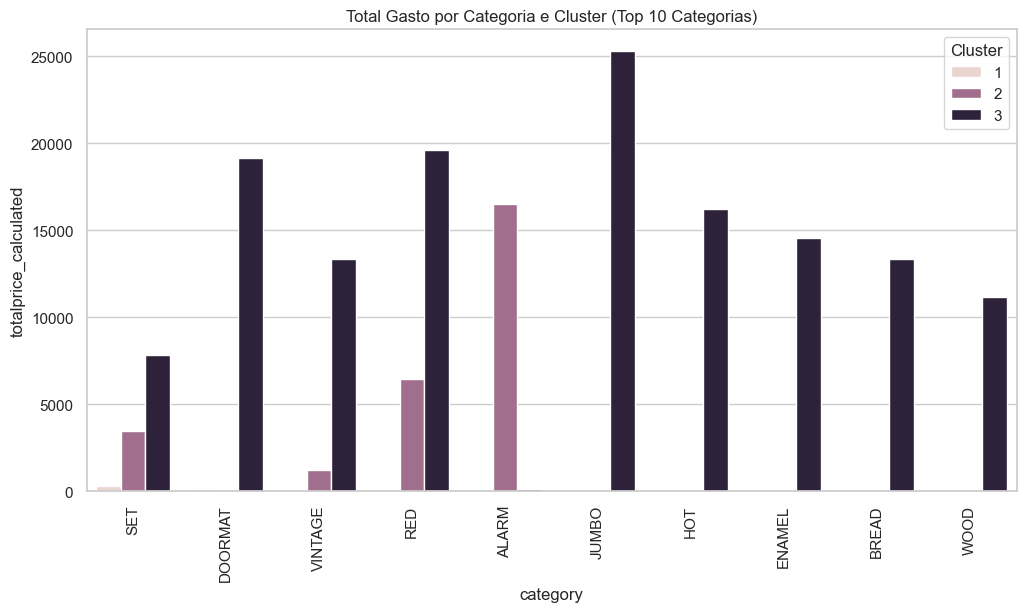

In [706]:

# Selecionar as 10 categorias mais gastas em totalprice_calculated
top_10_categories = (
    preferencias_cluster_sorted.groupby('category')['totalprice_calculated']
    .sum()
    .nlargest(10)
    .index
)

# Filtrar o DataFrame para incluir apenas essas 10 categorias
top_10_data = preferencias_cluster_sorted[preferencias_cluster_sorted['category'].isin(top_10_categories)]

# Gráfico de barras para visualizar preferências por cluster
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='totalprice_calculated', hue='Cluster', data=top_10_data)
plt.title('Total Gasto por Categoria e Cluster (Top 10 Categorias)')
plt.xticks(rotation=90)
plt.show()

   Cluster  totalprice_calculated
0        0                    0.0
1        1                 3079.1
2        2               107810.1
3        3               269898.3


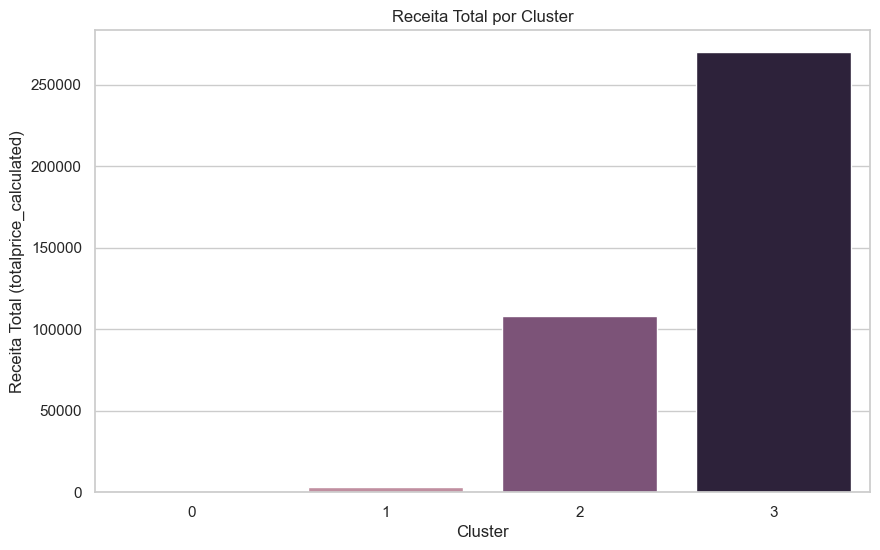

In [707]:
# Calcular a receita total por cluster
receita_por_cluster =preferencias_analise.groupby('Cluster')['totalprice_calculated'].sum().reset_index()

# Exibir a receita total por cluster
print(receita_por_cluster)

# Visualizar o resultado em um gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='totalprice_calculated', data=receita_por_cluster, hue='Cluster', dodge=False)
plt.title('Receita Total por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Receita Total (totalprice_calculated)')
plt.legend([], [], frameon=False)  
plt.show()



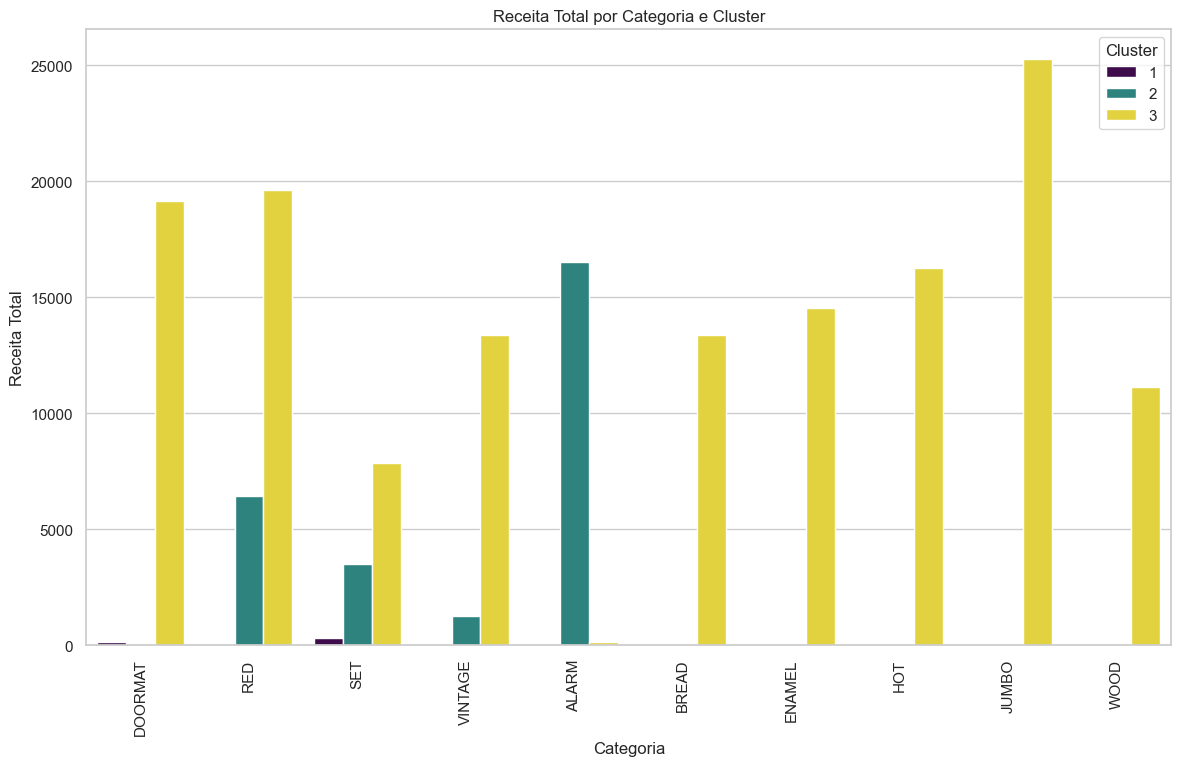

In [708]:
# Agrupar dados por Cluster e Categoria para calcular a receita total
receita_por_cluster_categoria = preferencias_cluster_sorted.groupby(['Cluster', 'category'])['totalprice_calculated'].sum().reset_index()

# Ajustar o DataFrame para exibir apenas as 10 principais categorias em receita por cluster
top_categorias = receita_por_cluster_categoria.groupby('category')['totalprice_calculated'].sum().nlargest(10).index
receita_top_categorias = receita_por_cluster_categoria[receita_por_cluster_categoria['category'].isin(top_categorias)]

# Gráfico de barras para visualizar a receita total por cluster e categoria
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='totalprice_calculated', hue='Cluster', data=receita_top_categorias, palette='viridis')
plt.title('Receita Total por Categoria e Cluster')
plt.xlabel('Categoria')
plt.ylabel('Receita Total')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.show()

Conclusão da Análise por Clusters

A análise de preferências e receita por clusters revela diferenças notáveis no comportamento e nos padrões de compra dos clientes segmentados. Observando o total gasto por categoria em cada cluster e a receita total gerada, destacam-se as seguintes tendências:

Cluster 3: 

Este grupo foi o mais lucrativo, contribuindo significativamente para o total gasto em diversas categorias, como "JUMBO", "DOORMAT" e "RED". Isso sugere que os clientes neste cluster têm um perfil de consumo mais elevado, o que pode indicar alta fidelidade e frequência de compras em itens de maior valor agregado.

Cluster 2: 

Embora menos expressivo que o Cluster 3 em termos de receita total, o Cluster 2 apresentou preferências fortes em categorias específicas, como "ALARM" e "VINTAGE". Esse comportamento pode indicar um público com preferências mais específicas, possivelmente influenciado por interesses em produtos de apelo nostálgico ou utilitário.

Cluster 1: 
Este cluster teve o menor gasto total e não apresentou uma forte preferência em categorias específicas. Isso pode sugerir um perfil de clientes menos engajados ou que realizam compras de menor valor e com menor frequência. Estratégias de retenção e personalização podem ser eficazes para aumentar o envolvimento deste grupo.

Implicações para Estratégias de Marketing
A segmentação baseada nos clusters permite criar campanhas direcionadas:

Para o Cluster 3, é recomendável promover produtos premium e pacotes personalizados, maximizando a fidelidade e explorando o potencial de gasto deste grupo.

Para o Cluster 2, campanhas focadas em itens populares dentro das preferências específicas, como relógios e produtos vintage, podem aumentar a retenção.

Para o Cluster 1, a prioridade deve ser estratégias de engajamento, oferecendo incentivos e benefícios que incentivem um aumento na frequência de compras.

# 4. Criação de Perfis Comportamentais






4.1. Análise de comportamento de navegação:

Verificar o tempo de permanência, páginas visualizadas, e padrões de abandono de carrinho.

In [709]:
# Explorar as compras por cliente
compras_por_cliente = df_e_commerce.groupby('customerid')['quantity'].sum().reset_index()

# Ver as 10 primeiras linhas
print(compras_por_cliente.head(10))

   customerid  quantity
0        -1.0    269562
1     12346.0         0
2     12347.0      2458
3     12348.0      2341
4     12349.0       631
5     12350.0       197
6     12352.0       470
7     12353.0        20
8     12354.0       530
9     12355.0       240


In [710]:
# Calcular o total gasto por cliente
df_e_commerce['total_gasto'] = df_e_commerce['quantity'] * df_e_commerce['unitprice']
total_gasto_por_cliente = df_e_commerce.groupby('customerid')['total_gasto'].sum().reset_index()

# Exibir os 10 maiores valores
print(total_gasto_por_cliente.sort_values(by='total_gasto', ascending=False).head(10))

      customerid  total_gasto
0           -1.0   1447682.12
1704     14646.0    279489.02
4234     18102.0    256438.49
3759     17450.0    187482.17
1896     14911.0    132572.62
56       12415.0    123725.45
1346     14156.0    113384.14
3802     17511.0     88125.38
3203     16684.0     65892.08
1006     13694.0     62653.10


4.2. Definir padrões de compra:

Identificar clientes que compram rapidamente (compradores imediatos) e os que só compram em promoções (caçadores de promoções).

In [711]:
# Certifique-se de que 'invoicedate' está no formato datetime
df_e_commerce['invoicedate'] = pd.to_datetime(df_e_commerce['invoicedate'], errors='coerce')

# Passo 1: Identificar Compradores Imediatos
# Vamos considerar compradores imediatos como aqueles com uma baixa frequência de tempo entre compras.
df_e_commerce['previous_purchase'] = df_e_commerce.groupby('customerid')['invoicedate'].shift(1)
df_e_commerce['time_diff'] = (df_e_commerce['invoicedate'] - df_e_commerce['previous_purchase']).dt.days

# Definir compradores imediatos como aqueles que têm um intervalo médio de compra menor que X dias (ajuste o valor conforme necessário)
comprador_imediato_limite = 7  # exemplo: intervalo médio de até 7 dias
df_e_commerce['tipo_comprador'] = df_e_commerce.groupby('customerid')['time_diff'].transform('mean').apply(
    lambda x: 'Comprador Imediato' if x <= comprador_imediato_limite else 'Outro'
)

# Passo 2: Identificar Caçadores de Promoções
# Para caçadores de promoções, podemos verificar se há uma diferença significativa no preço das compras.
df_e_commerce['price_diff'] = df_e_commerce.groupby('customerid')['unitprice'].transform('mean') - df_e_commerce['unitprice']

# Definir caçadores de promoções como aqueles que compram principalmente com grandes descontos
limite_desconto = 0.2  # 20% de desconto
df_e_commerce['tipo_comprador'] = df_e_commerce.apply(
    lambda row: 'Caçador de Promoções' if row['price_diff'] > limite_desconto else row['tipo_comprador'], axis=1
)

# Exibir a distribuição dos tipos de compradores
tipos_compradores = df_e_commerce['tipo_comprador'].value_counts()
print(tipos_compradores)

tipo_comprador
Caçador de Promoções    376810
Comprador Imediato      161723
Outro                     3376
Name: count, dtype: int64


4.3. Agrupamento comportamental:

Criar perfis comportamentais como navegadores frequentes e compradores ocasionais, e use esses dados para melhorar a experiência personalizada.

In [712]:
#  Calcular a frequência de compras e o total gasto por cliente
df_e_commerce['total_gasto'] = df_e_commerce['quantity'] * df_e_commerce['unitprice']
df_cliente_comportamento = df_e_commerce.groupby('customerid').agg(
    total_visitas=('quantity', 'count'),  # Número total de interações
    total_compras=('quantity', 'sum'),  # Quantidade total comprada
    total_gasto=('total_gasto', 'sum')  # Total gasto
).reset_index()

#  Definir um limite para "navegadores frequentes" e "compradores ocasionais"
limite_navegadores = df_cliente_comportamento['total_visitas'].quantile(0.75)  #  clientes acima do 75º percentil são navegadores frequentes
limite_compradores = df_cliente_comportamento['total_compras'].quantile(0.25)  # Compradores com menos de 25% das compras totais são ocasionais

# Criar as colunas de perfis comportamentais
df_cliente_comportamento['perfil_comportamental'] = df_cliente_comportamento.apply(
    lambda row: 'Navegador Frequente' if row['total_visitas'] > limite_navegadores else ('Comprador Ocacional' if row['total_compras'] <= limite_compradores else 'Outro'),
    axis=1
)

#  Verificar a distribuição dos perfis comportamentais
tipos_comportamentais = df_cliente_comportamento['perfil_comportamental'].value_counts()
print(tipos_comportamentais)


perfil_comportamental
Outro                  2193
Comprador Ocacional    1098
Navegador Frequente    1082
Name: count, dtype: int64


C:\Users\cladi\AppData\Local\Temp\ipykernel_34276\927095081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='perfil_comportamental', data=df_cliente_comportamento, palette='Set2')


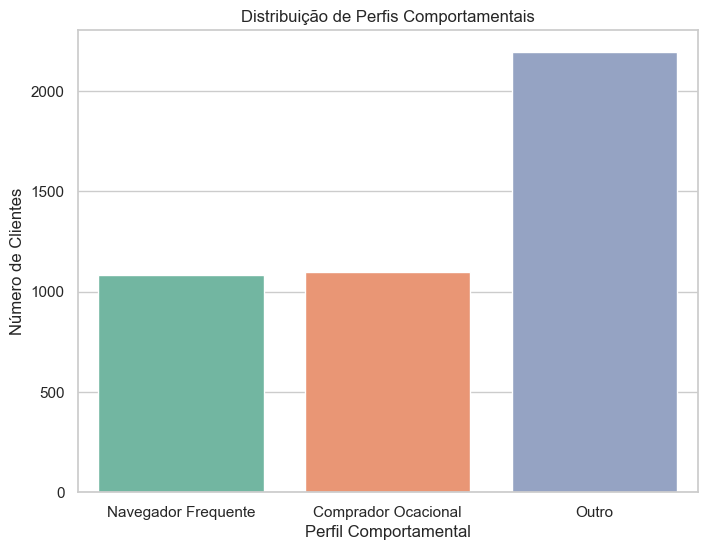

In [713]:

# Gráfico de barras para visualizar a distribuição de perfis comportamentais
plt.figure(figsize=(8, 6))
sns.countplot(x='perfil_comportamental', data=df_cliente_comportamento, palette='Set2')
plt.title('Distribuição de Perfis Comportamentais')
plt.xlabel('Perfil Comportamental')
plt.ylabel('Número de Clientes')
plt.show()

Estratégias para Personalização:

Ofertas Exclusivas e Descontos: Oferecer descontos direcionados ou cupons de promoção para incentivar a próxima compra, especialmente se eles já fizeram uma compra significativa anteriormente.

Exemplo: "Você comprou conosco antes! Que tal voltar e aproveitar 15% de desconto na sua próxima compra?"

E-mails de Recuperação de Carrinho Abandonado: Se um comprador ocasional deixar itens no carrinho, enviar e-mails ou mensagens lembrando-o sobre os itens e oferecendo um incentivo, como um desconto adicional ou frete grátis.

Exemplo: "Oi, [Nome]! Esqueceu algo no seu carrinho? Complete sua compra agora e ganhe 10% de desconto."

Campanhas Baseadas em Sazonalidade e Promoções: Criar campanhas de marketing focadas em datas sazonais (como Black Friday, Natal, etc.) para aproveitar o comportamento de compra esporádico e incentivar uma compra durante essas promoções.

Exemplo: "A Black Friday chegou! Aproveite as ofertas exclusivas e descontos de até 30%."
Programas de Fidelidade: Oferecer incentivos como pontos de fidelidade ou recompensas de compras futuras. Isso pode ajudar a transformar um comprador ocasional em um comprador mais frequente.


A análise de comportamentos de compra e navegação dos clientes permite uma segmentação eficaz e a criação de perfis personalizados, fundamentais para otimizar a experiência do usuário e aumentar a conversão de vendas. A partir dos perfis de navegadores frequentes, compradores ocasionais, compradores imediatos e caçadores de promoções, podemos adotar estratégias de marketing direcionadas que atendem às necessidades e preferências específicas de cada grupo.

Navegadores Frequentes podem ser incentivados a realizar compras por meio de lembretes personalizados, ofertas exclusivas e sugestões de produtos com base em seu histórico de navegação. Essas ações ajudam a transformar o interesse em compras reais.

Compradores Ocasionais podem ser atraídos de volta com descontos personalizados, campanhas de recuperação de carrinho e promoções sazonais. O objetivo aqui é criar um vínculo maior com o cliente e incentivá-lo a comprar com mais frequência.

O uso de RFM scores e clusters comportamentais permite uma abordagem mais precisa, criando campanhas ainda mais direcionadas para cada tipo de cliente, seja para premiar aqueles com alto engajamento ou recuperar aqueles com baixo desempenho.

No geral, ao personalizar a experiência de compra, a empresa pode aumentar o engajamento, melhorar a fidelização dos clientes e maximizar o valor do ciclo de vida de cada cliente. Além disso, a aplicação de estratégias baseadas em dados não só melhora a eficiência das campanhas de marketing, mas também contribui para uma experiência mais satisfatória e direcionada para cada grupo de clientes, resultando em maiores taxas de conversão e aumento da receita.

Se essas estratégias forem implementadas corretamente, a empresa terá a capacidade de se conectar de maneira mais eficaz com seus clientes, otimizando tanto o crescimento da receita quanto o relacionamento com o cliente ao longo do tempo.